# Assignment 3
## Murat Tirkeshov

In [49]:
import pandas as pd
import numpy as np
import holidays
import warnings
import sys
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from meteostat import Point, Hourly
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
try: 
    import holidays
except:
    !pip install holidays
    import holidays

try:
    from prophet import Prophet
except: 
    !pip install Prophet
    from prophet import Prophet

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


warnings.filterwarnings("ignore")

## Data
### Additional variables

In [50]:
df = pd.read_csv('data-2.csv')

In [51]:
df['ts'] = pd.to_datetime(df['ts'])


df['is_weekend'] = df['ts'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

us_holidays = holidays.UnitedStates(years=[2022, 2023, 2024])
start_year = df['ts'].dt.year.min()
end_year = df['ts'].dt.year.max()

#df['is_holiday'] = df['ts'].dt.date.apply(lambda d: 1 if d in us_holidays else 0)

hu_holidays = holidays.Hungary(years=range(start_year, end_year + 1))
budapest = Point(47.4979, 19.0402, 96)

start = datetime(2022, 1, 1)
end = datetime(2024, 12, 31)

data_hourly = Hourly(budapest, start, end)
data_hourly = data_hourly.fetch()

print(data_hourly.head())
top_threshold = df['v1'].quantile(0.85)
df['is_top_hour'] = df['v1'].apply(lambda x: 1 if x >= top_threshold else 0)

df['hour'] = df['ts'].dt.hour
df['dow'] = df['ts'].dt.dayofweek
df['year'] = df['ts'].dt.year
df['doy'] = df['ts'].dt.dayofyear
df['month'] = df['ts'].dt.month
#df['dom'] = df['ts'].dt.day
#df['time_index'] = (df['ts'] - df['ts'].min()).dt.total_seconds() / 3600
df['is_holiday'] = df['ts'].dt.date.apply(lambda d: 1 if d in hu_holidays else 0)
df['is_weekend_and_holiday'] = ((df['is_weekend'] == 1) & (df['is_holiday'] == 1)).astype(int)
#df['is_working_hour'] = df['hour'].apply(lambda h: 1 if 8 <= h <= 18 else 0)
df.head()

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2022-01-01 00:00:00   8.6   6.6  87.0   NaN   NaN  278.0   9.3  16.7  1020.4   
2022-01-01 01:00:00  10.3   6.1  75.0   NaN   NaN  286.0   8.6  18.5  1019.9   
2022-01-01 02:00:00   8.2   5.8  85.0   NaN   NaN  264.0   2.5  25.9  1020.2   
2022-01-01 03:00:00   9.0   6.4  84.0   NaN   NaN  298.0  16.7  27.8  1021.0   
2022-01-01 04:00:00  11.6   6.9  73.0   NaN   NaN  304.0  22.2  33.3  1020.0   

                     tsun  coco  
time                             
2022-01-01 00:00:00   NaN   3.0  
2022-01-01 01:00:00   NaN   3.0  
2022-01-01 02:00:00   NaN   3.0  
2022-01-01 03:00:00   NaN   3.0  
2022-01-01 04:00:00   NaN   3.0  


ts        v1        v2  is_weekend  is_top_hour  hour  dow  \
0 2022-01-01 00:00:00  0.999036  0.318587           1            0     0    5   
1 2022-01-01 01:00:00  0.695036  0.265836           1            0     1    5   
2 2022-01-01 02:00:00  0.764995  0.320261           1            0     2    5   
3 2022-01-01 03:00:00  0.297017  0.064074           1            0     3    5   
4 2022-01-01 04:00:00  0.366184  0.083961           1            0     4    5   

   year  doy  month  is_holiday  is_weekend_and_holiday  
0  2022    1      1           1                       1  
1  2022    1      1           1                       1  
2  2022    1      1           1                       1  
3  2022    1      1           1                       1  
4  2022    1      1           1                       1

In [ ]:
hourly_performance = df.groupby('hour')['v1'].mean().reset_index()

hourly_performance = hourly_performance.sort_values(by='v1', ascending=False)

print(hourly_performance.head(10))

    hour        v1
12    12  2.781810
13    13  2.575436
14    14  2.517835
11    11  2.413058
15    15  2.287777
10    10  2.228804
9      9  2.073679
16    16  1.957412
8      8  1.682765
17    17  1.489211


In [ ]:
hourly_performance = df.groupby('hour')['v2'].mean().reset_index()

hourly_performance = hourly_performance.sort_values(by='v2', ascending=False)

print(hourly_performance.head(10))

    hour        v2
12    12  0.608606
13    13  0.590218
14    14  0.576689
11    11  0.570253
15    15  0.558380
10    10  0.550365
9      9  0.524998
16    16  0.523254
8      8  0.466156
17    17  0.445801


In [ ]:
top_hours = [12, 13, 14]

#df['is_top_hour'] = df['hour'].apply(lambda x: 1 if x in top_hours else 0)

#print(df[['ts', 'hour', 'is_top_hour']].head(30))

In [ ]:
data_hourly = data_hourly.reset_index()
data_hourly = data_hourly[["time", "temp", "wspd"]]

data_hourly.rename(columns={"time": "ts"}, inplace=True)

#df = pd.merge(df, data_hourly, on='ts', how='left')

In [56]:
#df['season'] = df['ts'].dt.month.apply(lambda m: 1 if m in [12, 1, 2] 
#                                        else 2 if m in [3, 4, 5] 
#                                        else 3 if m in [6, 7, 8] 
#                                        else 4)
#print(df[['ts', 'season']].head())

As you can see I tried a lot of variables, but only some of them were usefull for the prediction

### Data Visualization

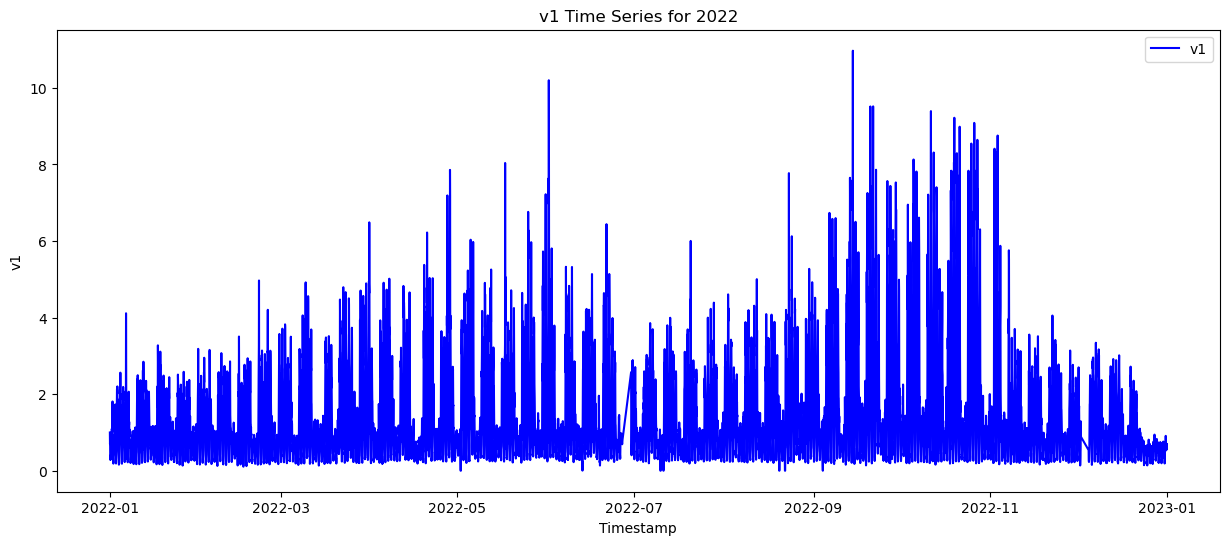

In [57]:
df_2022 = df[df['ts'].dt.year == 2022]

# Create the plot for v1 in 2022
plt.figure(figsize=(15, 6))
plt.plot(df_2022['ts'], df_2022['v1'], label='v1', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('v1')
plt.title('v1 Time Series for 2022')
plt.legend()
plt.show()

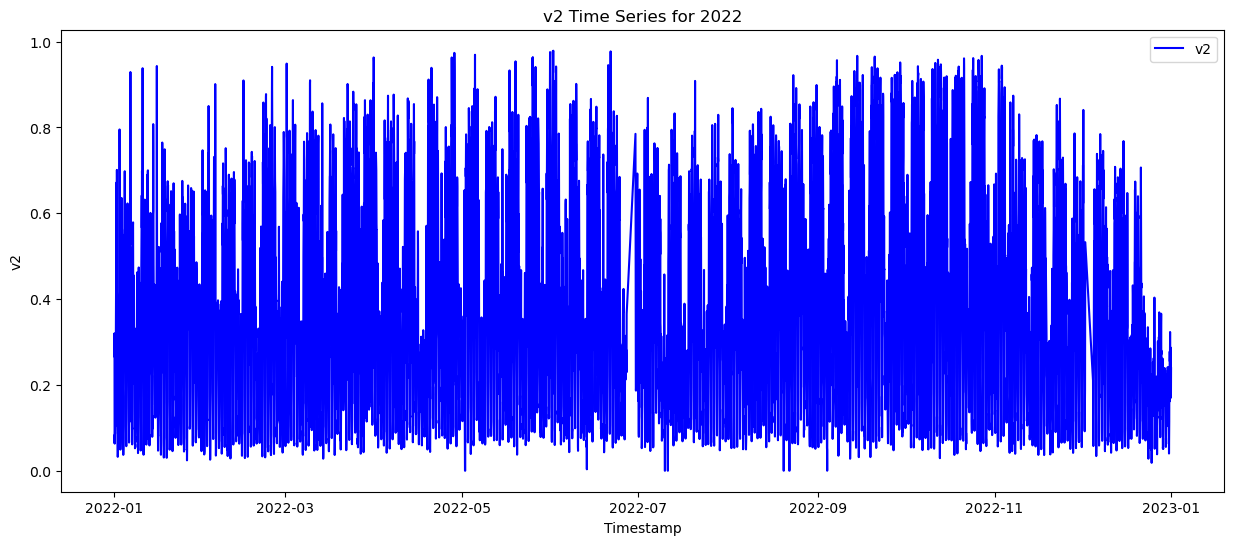

In [58]:
plt.figure(figsize=(15, 6))
plt.plot(df_2022['ts'], df_2022['v2'], label='v2', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('v2')
plt.title('v2 Time Series for 2022')
plt.legend()
plt.show()

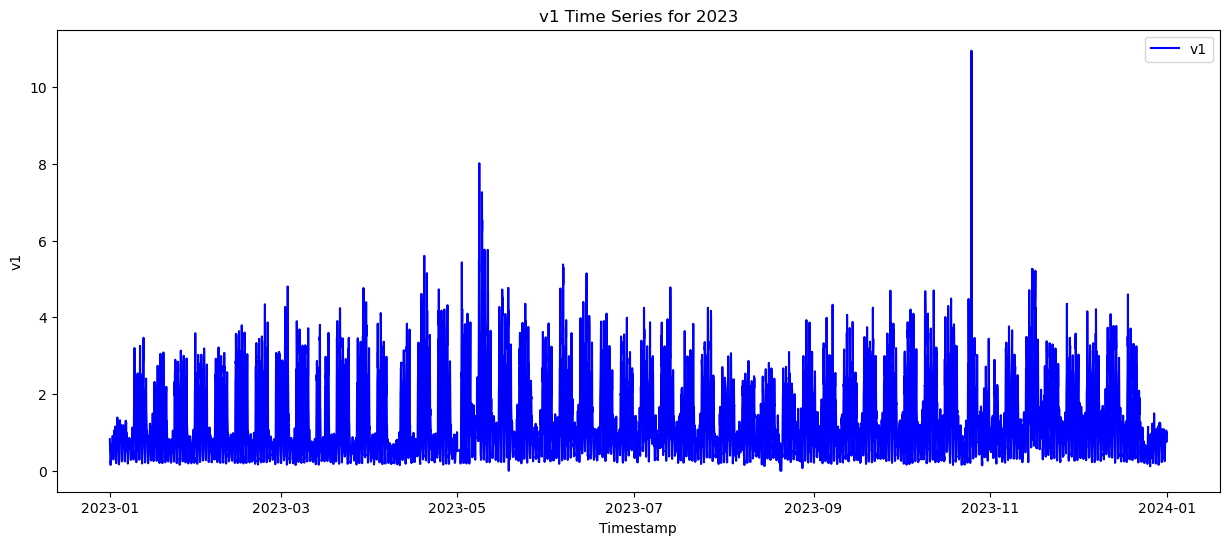

In [59]:
df_2023 = df[df['ts'].dt.year == 2023]

# Create the plot for v1 in 2022
plt.figure(figsize=(15, 6))
plt.plot(df_2023['ts'], df_2023['v1'], label='v1', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('v1')
plt.title('v1 Time Series for 2023')
plt.legend()
plt.show()

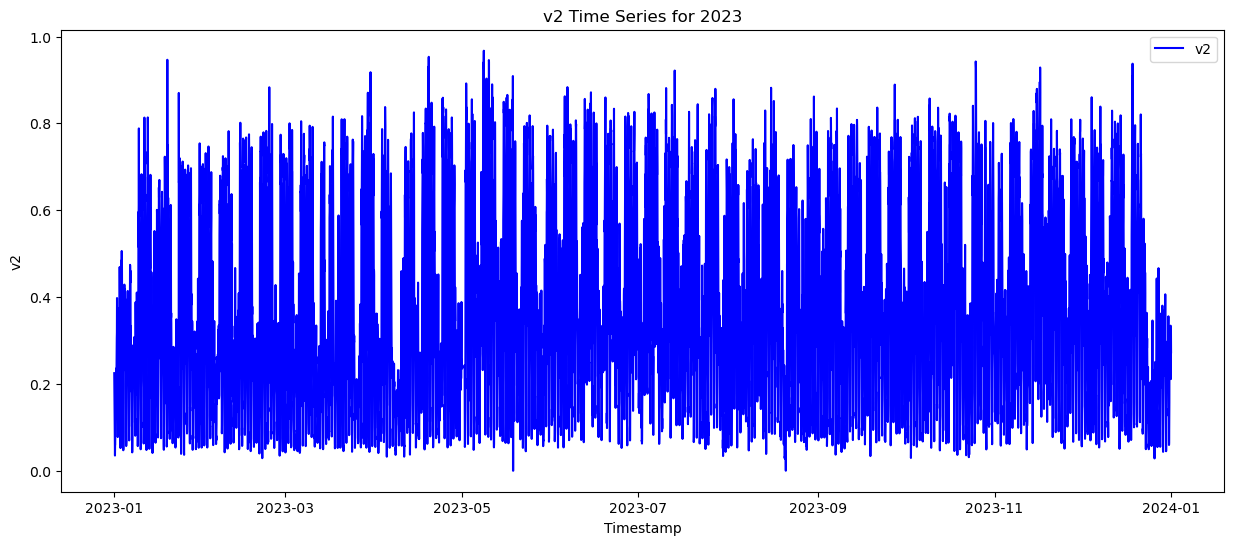

In [60]:
plt.figure(figsize=(15, 6))
plt.plot(df_2023['ts'], df_2023['v2'], label='v2', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('v2')
plt.title('v2 Time Series for 2023')
plt.legend()
plt.show()

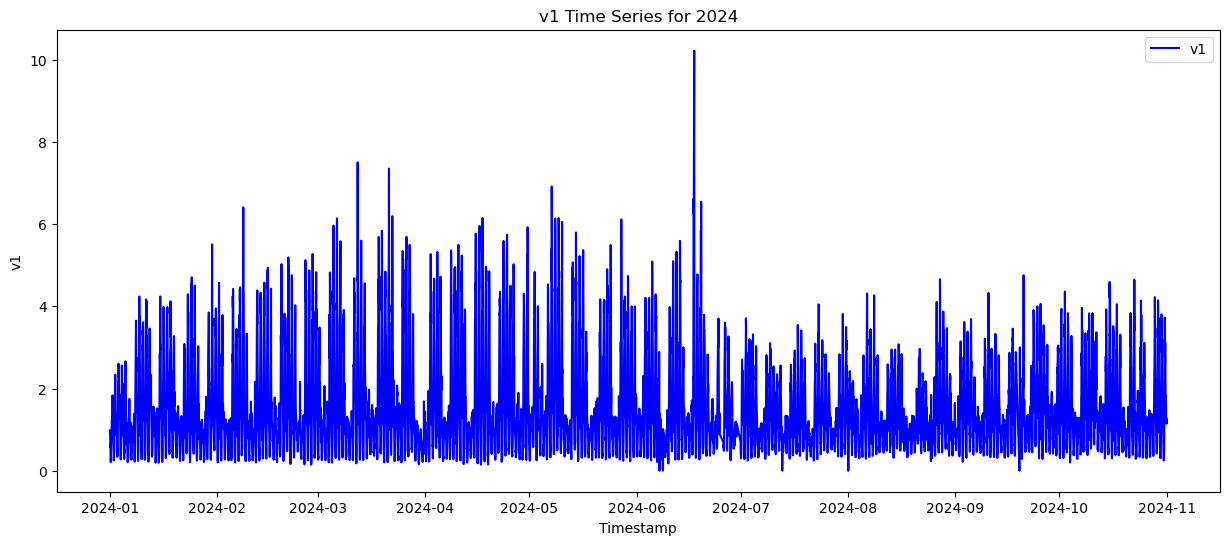

In [61]:
df_2024 = df[df['ts'].dt.year == 2024]

# Create the plot for v1 in 2022
plt.figure(figsize=(15, 6))
plt.plot(df_2024['ts'], df_2024['v1'], label='v1', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('v1')
plt.title('v1 Time Series for 2024')
plt.legend()
plt.show()

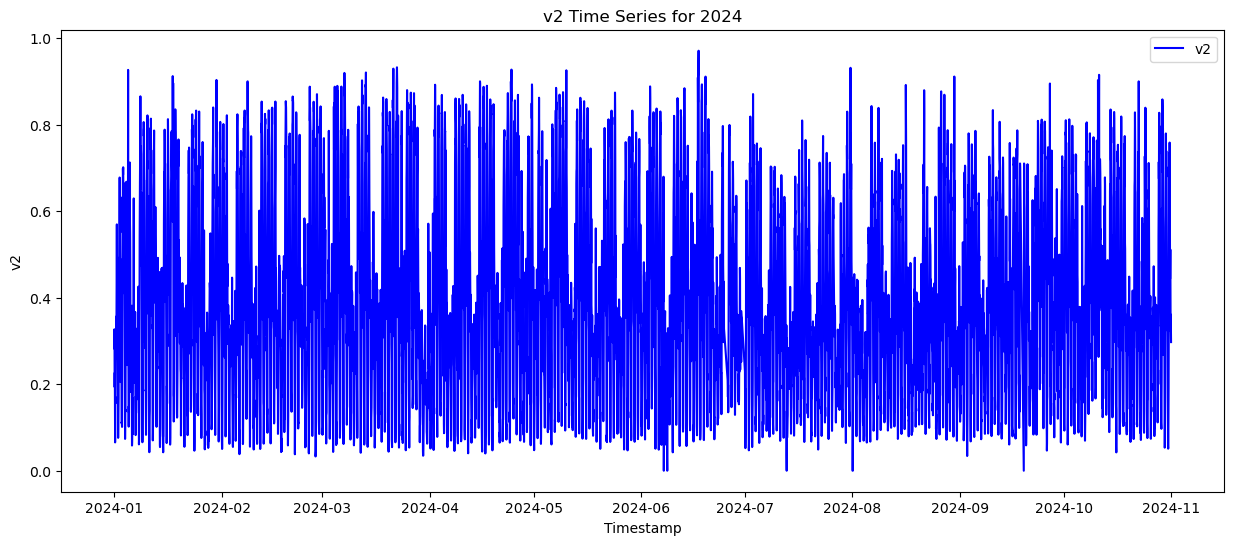

In [132]:
df_2024 = df[df['ts'].dt.year == 2024]

# Create the plot for v1 in 2022
plt.figure(figsize=(15, 6))
plt.plot(df_2024['ts'], df_2024['v2'], label='v2', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('v2')
plt.title('v2 Time Series for 2024')
plt.legend()
plt.show()

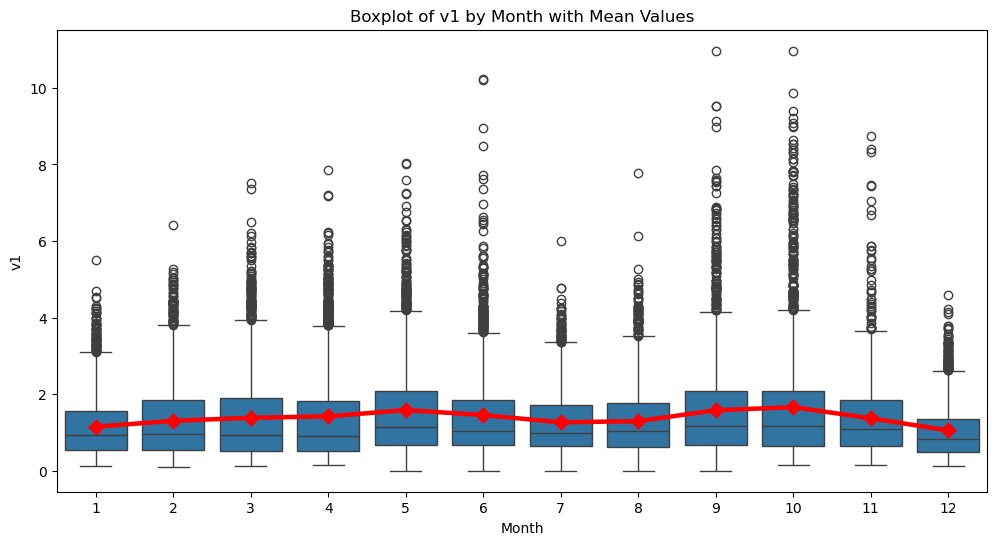

In [129]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='v1', data=df)

# Calculate mean v1 for each month
mean_v1 = df.groupby('month')['v1'].mean().reset_index()

# Overlay the mean values using a point plot
sns.pointplot(x='month', y='v1', data=mean_v1, color='red', markers='D', scale=1.2, errwidth=0)

plt.xlabel('Month')
plt.ylabel('v1')
plt.title('Boxplot of v1 by Month with Mean Values')
plt.show()

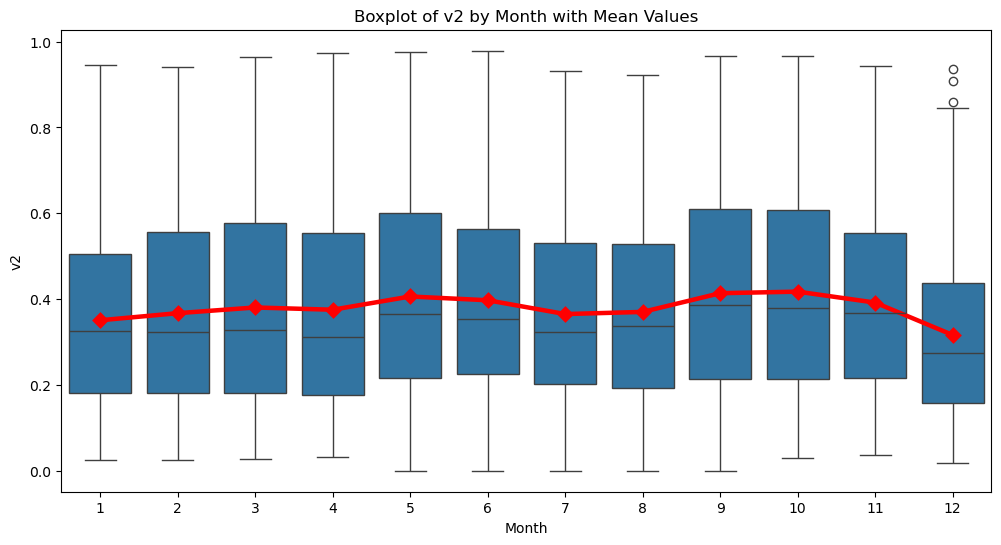

In [133]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='v2', data=df)

# Calculate mean v1 for each month
mean_v1 = df.groupby('month')['v2'].mean().reset_index()

# Overlay the mean values using a point plot
sns.pointplot(x='month', y='v2', data=mean_v1, color='red', markers='D', scale=1.2, errwidth=0)

plt.xlabel('Month')
plt.ylabel('v2')
plt.title('Boxplot of v2 by Month with Mean Values')
plt.show()

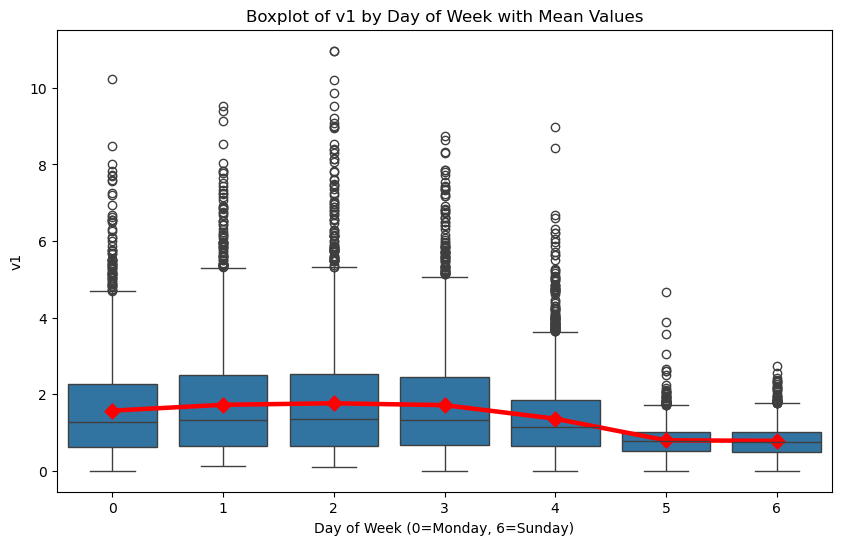

In [126]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='dow', y='v1', data=df)

# Calculate the mean v1 value for each day of the week.
mean_v1 = df.groupby('dow')['v1'].mean().reset_index()

# Overlay the mean values using a point plot
sns.pointplot(x='dow', y='v1', data=mean_v1, color='red', markers='D', scale=1.2, errwidth=0)

plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('v1')
plt.title('Boxplot of v1 by Day of Week with Mean Values')
plt.show()

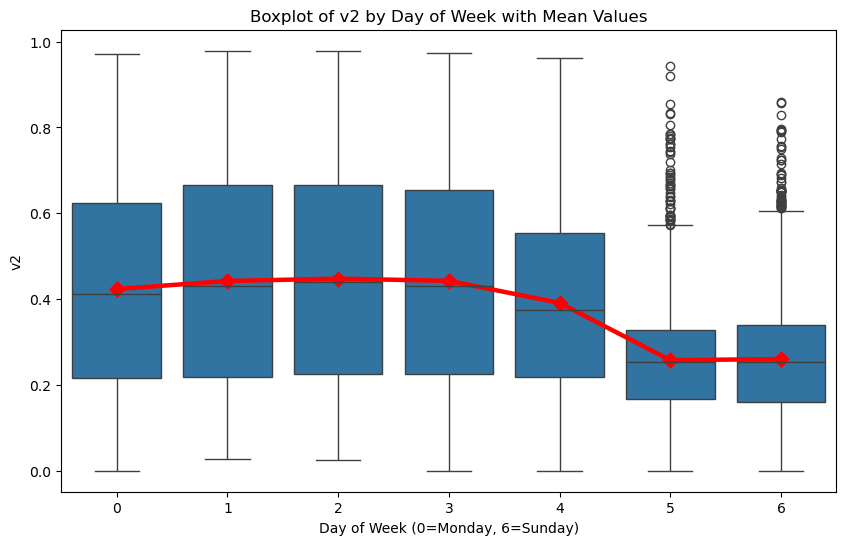

In [134]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='dow', y='v2', data=df)

# Calculate the mean v1 value for each day of the week.
mean_v1 = df.groupby('dow')['v2'].mean().reset_index()

# Overlay the mean values using a point plot
sns.pointplot(x='dow', y='v2', data=mean_v1, color='red', markers='D', scale=1.2, errwidth=0)

plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('v2')
plt.title('Boxplot of v2 by Day of Week with Mean Values')
plt.show()

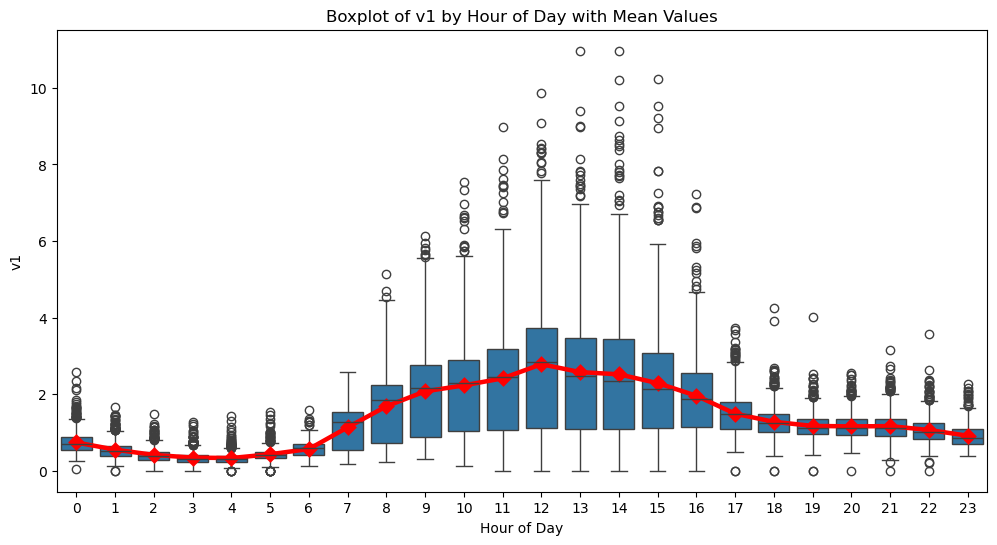

In [127]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='v1', data=df)

# Calculate mean v1 for each hour
mean_v1 = df.groupby('hour')['v1'].mean().reset_index()

# Overlay the mean values using a point plot
sns.pointplot(x='hour', y='v1', data=mean_v1, color='red', markers='D', scale=1.2, errwidth=0)

plt.xlabel('Hour of Day')
plt.ylabel('v1')
plt.title('Boxplot of v1 by Hour of Day with Mean Values')
plt.show()

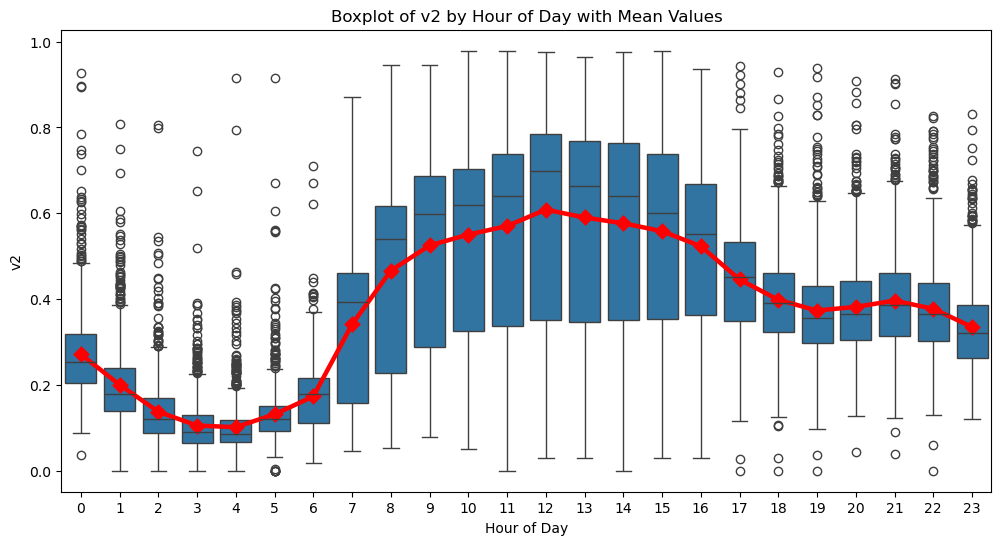

In [137]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='v2', data=df)

# Calculate mean v1 for each hour
mean_v1 = df.groupby('hour')['v2'].mean().reset_index()

# Overlay the mean values using a point plot
sns.pointplot(x='hour', y='v2', data=mean_v1, color='red', markers='D', scale=1.2, errwidth=0)

plt.xlabel('Hour of Day')
plt.ylabel('v2')
plt.title('Boxplot of v2 by Hour of Day with Mean Values')
plt.show()

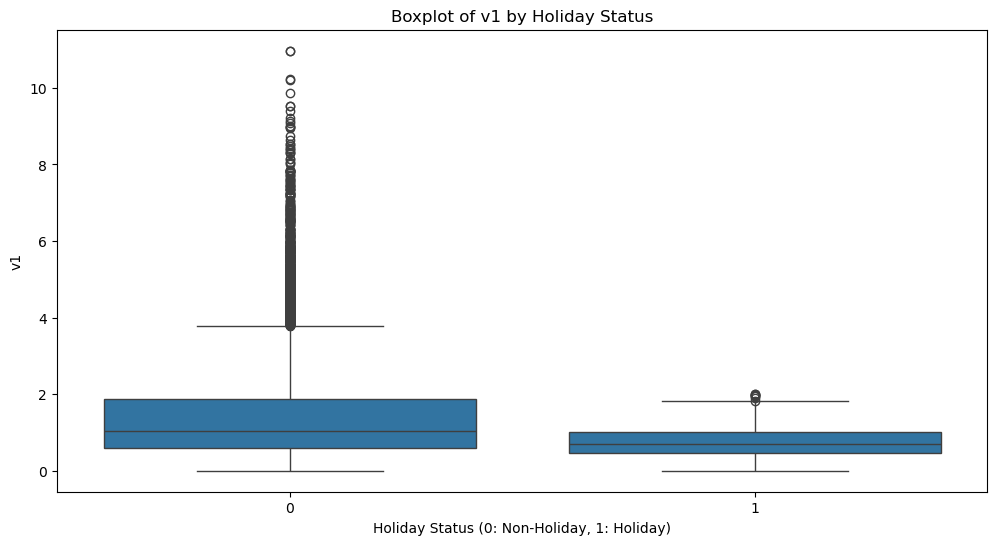

In [131]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_holiday', y='v1', data=df)
plt.xlabel('Holiday Status (0: Non-Holiday, 1: Holiday)')
plt.ylabel('v1')
plt.title('Boxplot of v1 by Holiday Status')
plt.show()

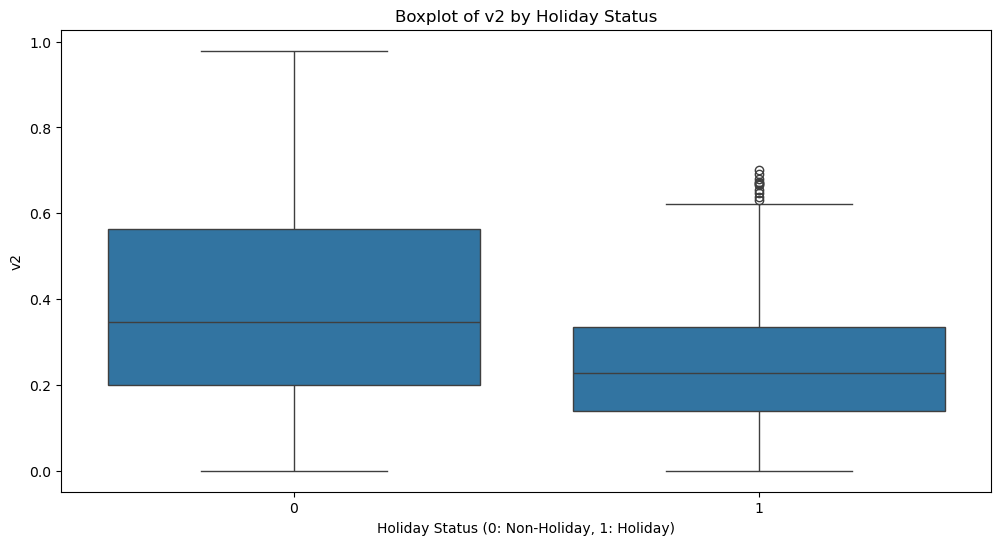

In [138]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_holiday', y='v2', data=df)
plt.xlabel('Holiday Status (0: Non-Holiday, 1: Holiday)')
plt.ylabel('v2')
plt.title('Boxplot of v2 by Holiday Status')
plt.show()

previous years november data

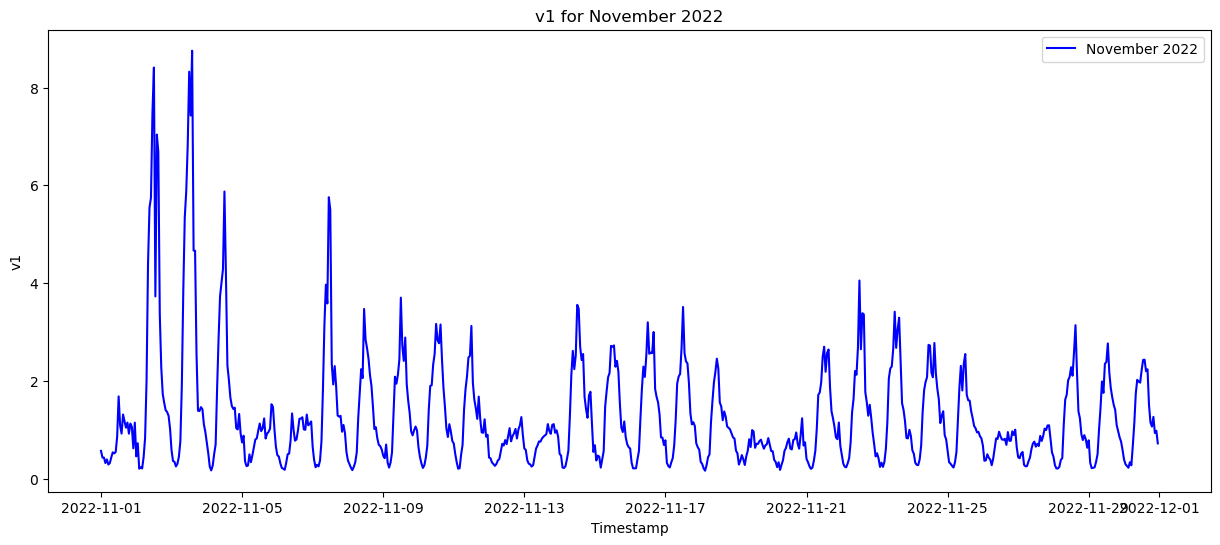

In [119]:
df_november = df[
    ((df['ts'].dt.year == 2022)) & 
    (df['ts'].dt.month == 11)
]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_november[df_november['ts'].dt.year == 2022]['ts'], 
         df_november[df_november['ts'].dt.year == 2022]['v1'], 
         label='November 2022', color='blue')


plt.xlabel('Timestamp')
plt.ylabel('v1')
plt.title('v1 for November 2022')
plt.legend()
plt.show()

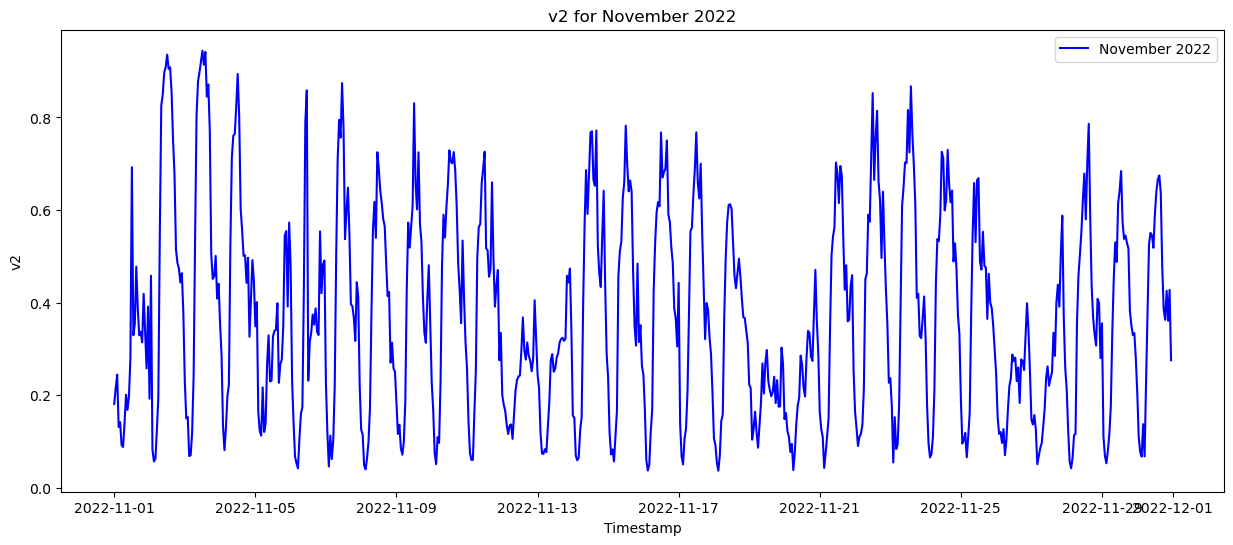

In [136]:
df_november = df[
    ((df['ts'].dt.year == 2022)) & 
    (df['ts'].dt.month == 11)
]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_november[df_november['ts'].dt.year == 2022]['ts'], 
         df_november[df_november['ts'].dt.year == 2022]['v2'], 
         label='November 2022', color='blue')


plt.xlabel('Timestamp')
plt.ylabel('v2')
plt.title('v2 for November 2022')
plt.legend()
plt.show()

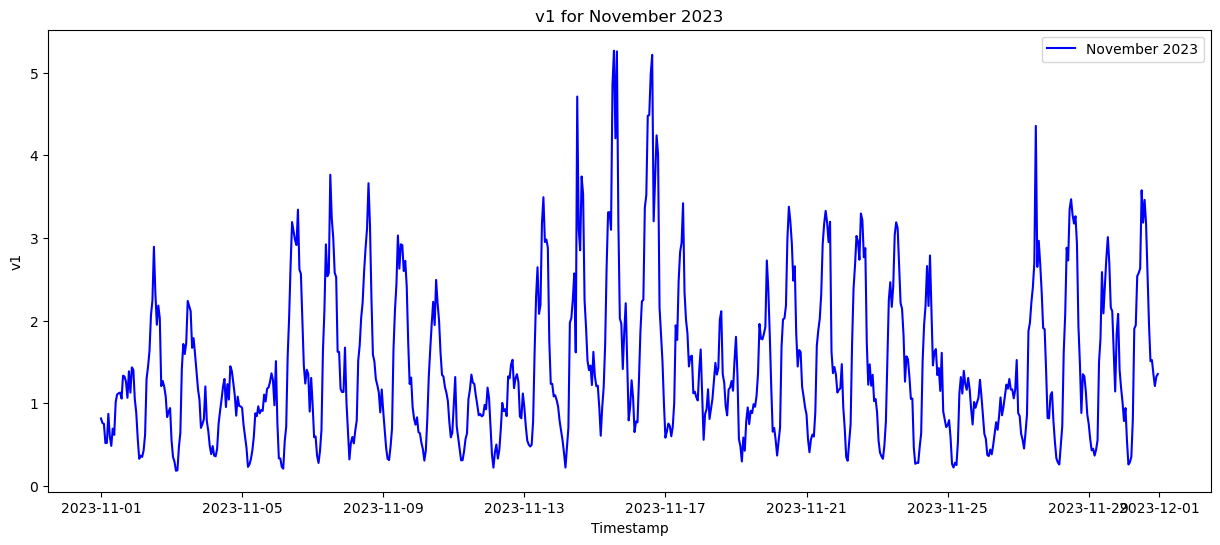

In [121]:
df_november = df[
    ((df['ts'].dt.year == 2023)) & 
    (df['ts'].dt.month == 11)
]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_november[df_november['ts'].dt.year == 2023]['ts'], 
         df_november[df_november['ts'].dt.year == 2023]['v1'], 
         label='November 2023', color='blue')


plt.xlabel('Timestamp')
plt.ylabel('v1')
plt.title('v1 for November 2023')
plt.legend()
plt.show()

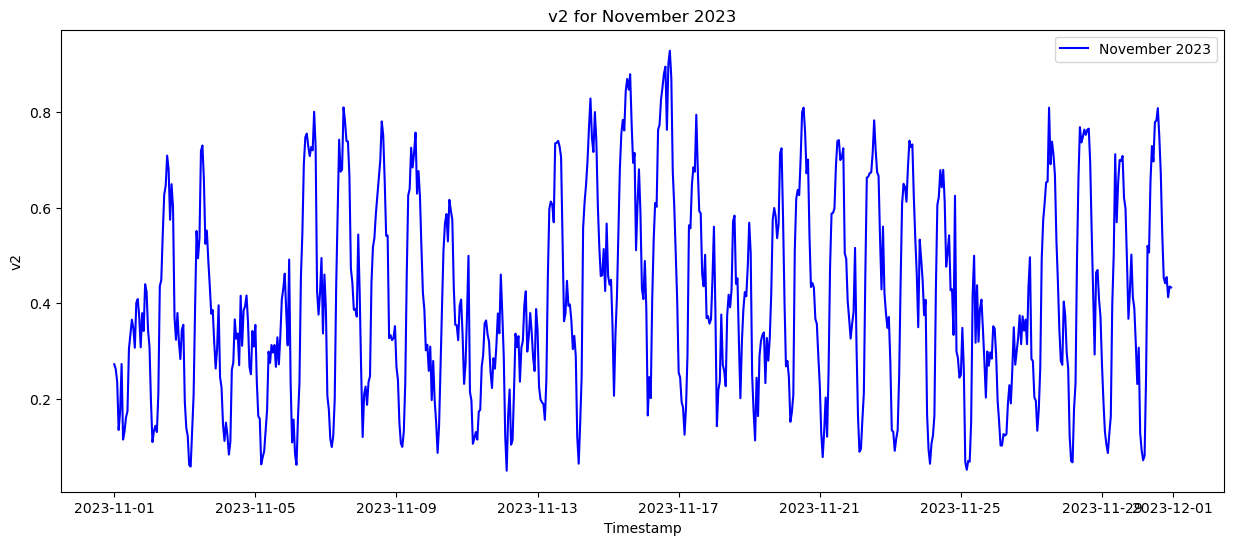

In [135]:
df_november = df[
    ((df['ts'].dt.year == 2023)) & 
    (df['ts'].dt.month == 11)
]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(df_november[df_november['ts'].dt.year == 2023]['ts'], 
         df_november[df_november['ts'].dt.year == 2023]['v2'], 
         label='November 2023', color='blue')


plt.xlabel('Timestamp')
plt.ylabel('v2')
plt.title('v2 for November 2023')
plt.legend()
plt.show()

### Creating test and train data

In [62]:
df = df.sort_values('ts')
df.set_index('ts', inplace=True)

In [63]:
test_start_date = '2024-10-01'
train = df.loc[:'2024-09-30']
test = df.loc[test_start_date:]

In [64]:
df.reset_index(inplace=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True) 

In [65]:
print(train.dtypes)

ts                        datetime64[ns]
v1                               float64
v2                               float64
is_weekend                         int64
is_top_hour                        int64
hour                               int32
dow                                int32
year                               int32
doy                                int32
month                              int32
is_holiday                         int64
is_weekend_and_holiday             int64
dtype: object


In [66]:
print(df.dtypes)

ts                        datetime64[ns]
v1                               float64
v2                               float64
is_weekend                         int64
is_top_hour                        int64
hour                               int32
dow                                int32
year                               int32
doy                                int32
month                              int32
is_holiday                         int64
is_weekend_and_holiday             int64
dtype: object


### Prophet
first tryying to predict v2 then using v2 predict v1 as in the assignment it was given that they are connected.

In [67]:
df_v2_train = train[['ts', 'v2']].rename(columns={'ts': 'ds', 'v2': 'y'})

# Build the Prophet model for v2
model_v2 = Prophet(
    seasonality_mode="additive",
    yearly_seasonality=True,
    weekly_seasonality=True,
    growth="linear",
    daily_seasonality=True,
)
model_v2.add_country_holidays(country_name='US')

# Fit the v2 model
model_v2.fit(df_v2_train)


01:22:01 - cmdstanpy - INFO - Chain [1] start processing
01:22:04 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
cv_v2 = cross_validation(model_v2, initial='365 days', period='365 days', horizon='30 days')
metrics_v2 = performance_metrics(cv_v2, rolling_window=1)
rmse_v2_cv = metrics_v2['rmse'].iloc[0]
print("v2 Prophet CV RMSE:", rmse_v2_cv)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

01:22:05 - cmdstanpy - INFO - Chain [1] start processing
01:22:06 - cmdstanpy - INFO - Chain [1] done processing
01:22:06 - cmdstanpy - INFO - Chain [1] start processing
01:22:09 - cmdstanpy - INFO - Chain [1] done processing


v2 Prophet CV RMSE: 0.11850430480259631


In [69]:
future_v2 = test[['ts']].rename(columns={'ts': 'ds'})
forecast_v2 = model_v2.predict(future_v2)

In [70]:
test = test.copy()  # to avoid SettingWithCopyWarning
test['v2_pred'] = forecast_v2['yhat'].values

In [71]:
df_v1_train = train[['ts', 'v1', 'v2']].rename(columns={'ts': 'ds', 'v1': 'y'})

In [72]:
model_v1 = Prophet(
    seasonality_mode="additive",
    yearly_seasonality=True,
    weekly_seasonality=True,
    growth="linear",
    daily_seasonality=True,
)
model_v1.add_country_holidays(country_name='US')
model_v1.add_regressor('v2')  # extra regressor

In [73]:
model_v1.fit(df_v1_train)

01:22:10 - cmdstanpy - INFO - Chain [1] start processing
01:22:15 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
cv_results = cross_validation(model_v1, initial='365 days', period='180 days', horizon='30 days')

# Compute performance metrics, using a rolling window of 1 (i.e., no additional smoothing).
cv_metrics = performance_metrics(cv_results, rolling_window=1)

print(cv_metrics)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/4 [00:00<?, ?it/s]

01:22:15 - cmdstanpy - INFO - Chain [1] start processing
01:22:16 - cmdstanpy - INFO - Chain [1] done processing
01:22:16 - cmdstanpy - INFO - Chain [1] start processing
01:22:18 - cmdstanpy - INFO - Chain [1] done processing
01:22:18 - cmdstanpy - INFO - Chain [1] start processing
01:22:21 - cmdstanpy - INFO - Chain [1] done processing
01:22:22 - cmdstanpy - INFO - Chain [1] start processing
01:22:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon       mse      rmse       mae     mdape     smape  coverage
0 30 days  0.133046  0.364755  0.254033  0.175541  0.251346  0.923966


In [75]:
future_v1 = test[['ts', 'v2_pred']].rename(columns={'ts': 'ds', 'v2_pred': 'v2'})

# Forecast v1 for the test period using the model with the extra regressor
forecast_v1 = model_v1.predict(future_v1)

In [76]:
r2_v1 = r2_score(test['v1'], forecast_v1['yhat'])
print("v1 Prophet with extra regressor (predicted v2) R² on test:", r2_v1)

v1 Prophet with extra regressor (predicted v2) R² on test: 0.707282740268124


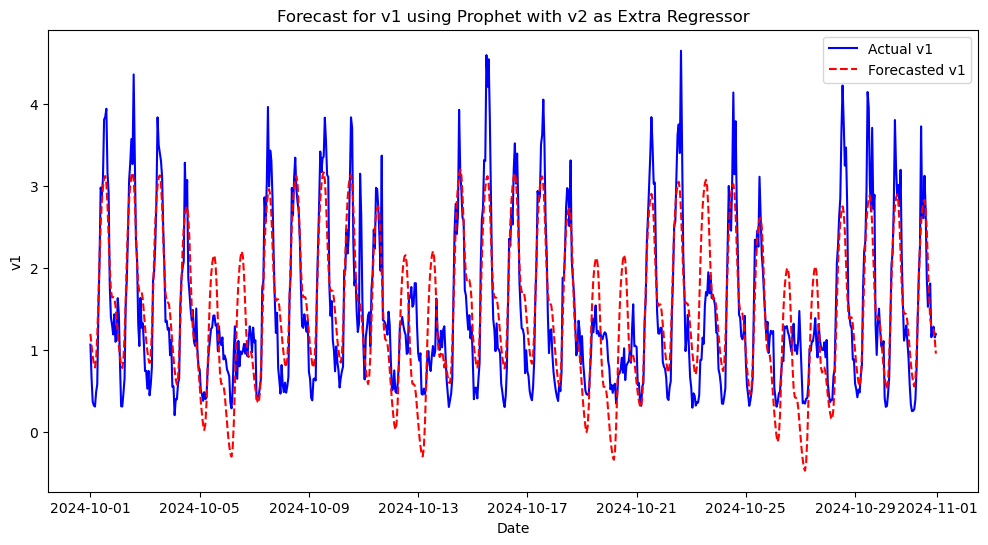

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(test['ts'], test['v1'], label='Actual v1', color='blue')
plt.plot(test['ts'], forecast_v1['yhat'], label='Forecasted v1', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('v1')
plt.title('Forecast for v1 using Prophet with v2 as Extra Regressor')
plt.legend()
plt.show()

In [78]:
df_v2_train_reg = train[['ts', 'v2', 'v1']].rename(columns={'ts': 'ds'})
# Prophet expects the target column to be named "y" and extra regressor columns to keep their names.
df_v2_train_reg.rename(columns={'v2': 'y'}, inplace=True)

# Build the Prophet model for v2
model_v2_with_v1 = Prophet(
    seasonality_mode="additive",
    yearly_seasonality=True,
    weekly_seasonality=True,
    growth="linear",
    daily_seasonality=True,
)
model_v2_with_v1.add_country_holidays(country_name='US')
# Add v1 as an extra regressor
model_v2_with_v1.add_regressor('v1')

# Fit the model on training data
model_v2_with_v1.fit(df_v2_train_reg)

01:22:28 - cmdstanpy - INFO - Chain [1] start processing
01:22:31 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
cv_results = cross_validation(model_v2_with_v1, initial='365 days', period='180 days', horizon='30 days')

# Compute performance metrics, using a rolling window of 1 (i.e., no additional smoothing).
cv_metrics = performance_metrics(cv_results, rolling_window=1)

print(cv_metrics)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/4 [00:00<?, ?it/s]

01:22:32 - cmdstanpy - INFO - Chain [1] start processing
01:22:32 - cmdstanpy - INFO - Chain [1] done processing
01:22:33 - cmdstanpy - INFO - Chain [1] start processing
01:22:34 - cmdstanpy - INFO - Chain [1] done processing
01:22:35 - cmdstanpy - INFO - Chain [1] start processing
01:22:36 - cmdstanpy - INFO - Chain [1] done processing
01:22:37 - cmdstanpy - INFO - Chain [1] start processing
01:22:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon       mse      rmse       mae     mdape     smape  coverage
0 30 days  0.005308  0.072859  0.055185  0.131038  0.202367  0.862649


In [80]:
future_v2_new = test[['ts']].copy().rename(columns={'ts': 'ds'})
# Add the predicted v1 values; ensure alignment between forecast_v1 and test.
future_v2_new['v1'] = forecast_v1['yhat'].values

# --------------------------------------------------
# 3. Forecast v2 using the new model with extra regressor v1
# --------------------------------------------------

forecast_v2_new = model_v2_with_v1.predict(future_v2_new)

# Add these new predictions to the test DataFrame
test = test.copy()  # Avoid SettingWithCopyWarning
test['v2_pred_with_v1'] = forecast_v2_new['yhat'].values

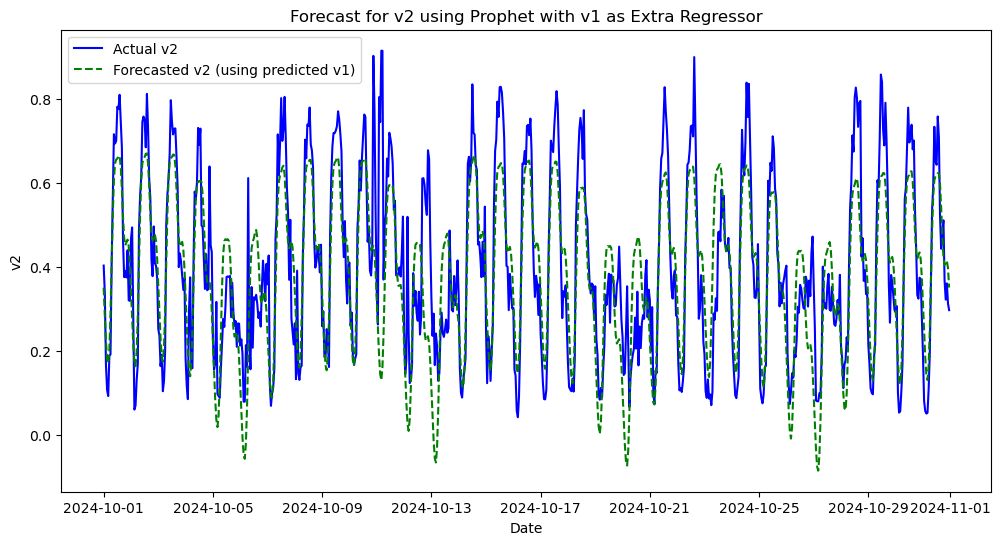

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(test['ts'], test['v2'], label='Actual v2', color='blue')
plt.plot(test['ts'], test['v2_pred_with_v1'], label='Forecasted v2 (using predicted v1)', 
         color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('v2')
plt.title('Forecast for v2 using Prophet with v1 as Extra Regressor')
plt.legend()
plt.show()

R² for initial v2 prediction: 0.6481038594079187
R² for v2 prediction using predicted v1: 0.6407235908692419


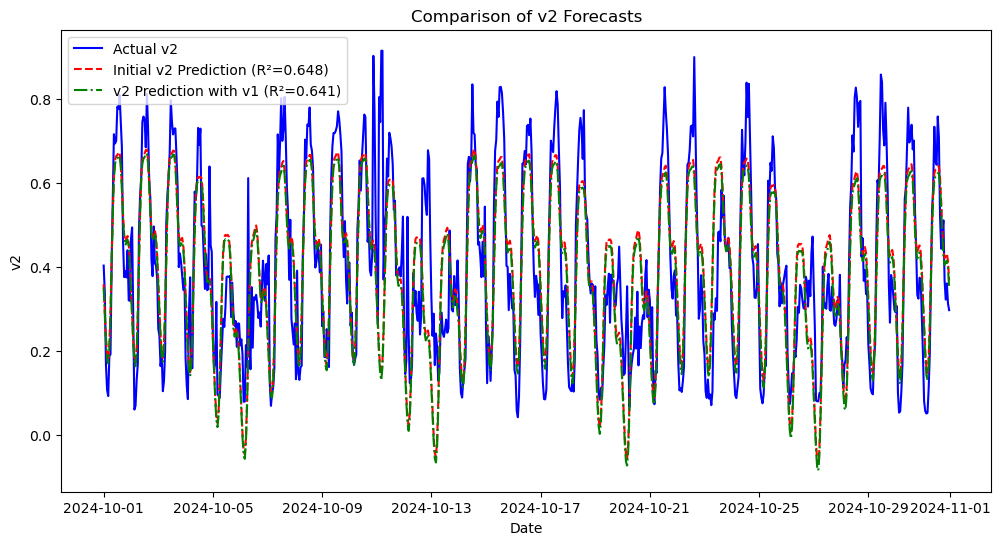

In [34]:
r2_initial = r2_score(test['v2'], test['v2_pred'])
r2_new = r2_score(test['v2'], test['v2_pred_with_v1'])

print("R² for initial v2 prediction:", r2_initial)
print("R² for v2 prediction using predicted v1:", r2_new)

# Plot the actual v2, initial v2 prediction, and new v2 prediction
plt.figure(figsize=(12, 6))
plt.plot(test['ts'], test['v2'], label='Actual v2', color='blue')
plt.plot(test['ts'], test['v2_pred'], label=f'Initial v2 Prediction (R²={r2_initial:.3f})', color='red', linestyle='--')
plt.plot(test['ts'], test['v2_pred_with_v1'], label=f'v2 Prediction with v1 (R²={r2_new:.3f})', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('v2')
plt.title('Comparison of v2 Forecasts')
plt.legend()
plt.show()

As we can see from the results predicting v2 again after using v1 lead to a worse results. I don't think that using connections between these variables that usefull, because we don't have real data on one or another it doesn't help

### ARIMAX

In [35]:
def create_exog_features(df):
    df_exog = df.copy()

    hour_dummies  = pd.get_dummies(df_exog['hour'], prefix='hour', drop_first=False)
    dow_dummies   = pd.get_dummies(df_exog['dow'], prefix='dow', drop_first=False)
    month_dummies = pd.get_dummies(df_exog['month'], prefix='month', drop_first=True)
    
    # Combine all dummy variables into a single exogenous DataFrame
    exog = pd.concat([hour_dummies, dow_dummies, month_dummies], axis=1)
    return exog


In [36]:
exog_train = create_exog_features(train)
exog_test  = create_exog_features(test)
exog_train = exog_train.astype(float)
exog_test  = exog_test.astype(float)


In [37]:
model_v2 = SARIMAX(train['v2'], order=(3, 0, 0), exog=exog_train)
model_v2_fit = model_v2.fit(disp=False)
print(model_v2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     v2   No. Observations:                23848
Model:               SARIMAX(3, 0, 0)   Log Likelihood               25717.764
Date:                Thu, 20 Mar 2025   AIC                         -51343.529
Time:                        01:17:57   BIC                         -50971.874
Sample:                             0   HQIC                        -51222.963
                              - 23848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_0      8.115e+08      0.004   2.17e+11      0.000    8.12e+08    8.12e+08
hour_1      8.115e+08      0.004   2.08e+11      0.000    8.12e+08    8.12e+08
hour_2      8.115e+08      0.004   1.87e+11      0.0

In [38]:


exog_test = exog_test.reindex(columns=exog_train.columns, fill_value=0)
forecast_v2 = model_v2_fit.get_forecast(steps=len(test), exog=exog_test)
v2_pred = forecast_v2.predicted_mean

In [39]:
r2_v2 = r2_score(test['v2'], v2_pred)
print("R² for v2 ARIMAX model:", r2_v2)

R² for v2 ARIMAX model: 0.5733362550582839


In [40]:
exog_train_v1 = exog_train.copy()
exog_train_v1['v2'] = train['v2']

In [41]:
exog_test_v1 = exog_test.copy()
exog_test_v1['v2'] = v2_pred.values


In [42]:
model_v1 = SARIMAX(train['v1'], order=(3, 0, 0), exog=exog_train_v1)
model_v1_fit = model_v1.fit(disp=False)
print(model_v1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     v1   No. Observations:                23848
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -5503.227
Date:                Thu, 20 Mar 2025   AIC                          11100.455
Time:                        01:19:46   BIC                          11480.189
Sample:                             0   HQIC                         11223.642
                              - 23848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_0      5.735e+09      0.021   2.67e+11      0.000    5.73e+09    5.73e+09
hour_1      5.735e+09      0.022   2.65e+11      0.000    5.73e+09    5.73e+09
hour_2      5.735e+09      0.024   2.35e+11      0.0

In [43]:
forecast_v1 = model_v1_fit.get_forecast(steps=len(test), exog=exog_test_v1)
v1_pred = forecast_v1.predicted_mean

In [44]:
r2_v1 = r2_score(test['v1'], v1_pred)
print("R² for v1 ARIMAX model:", r2_v1)

R² for v1 ARIMAX model: 0.588732447430625


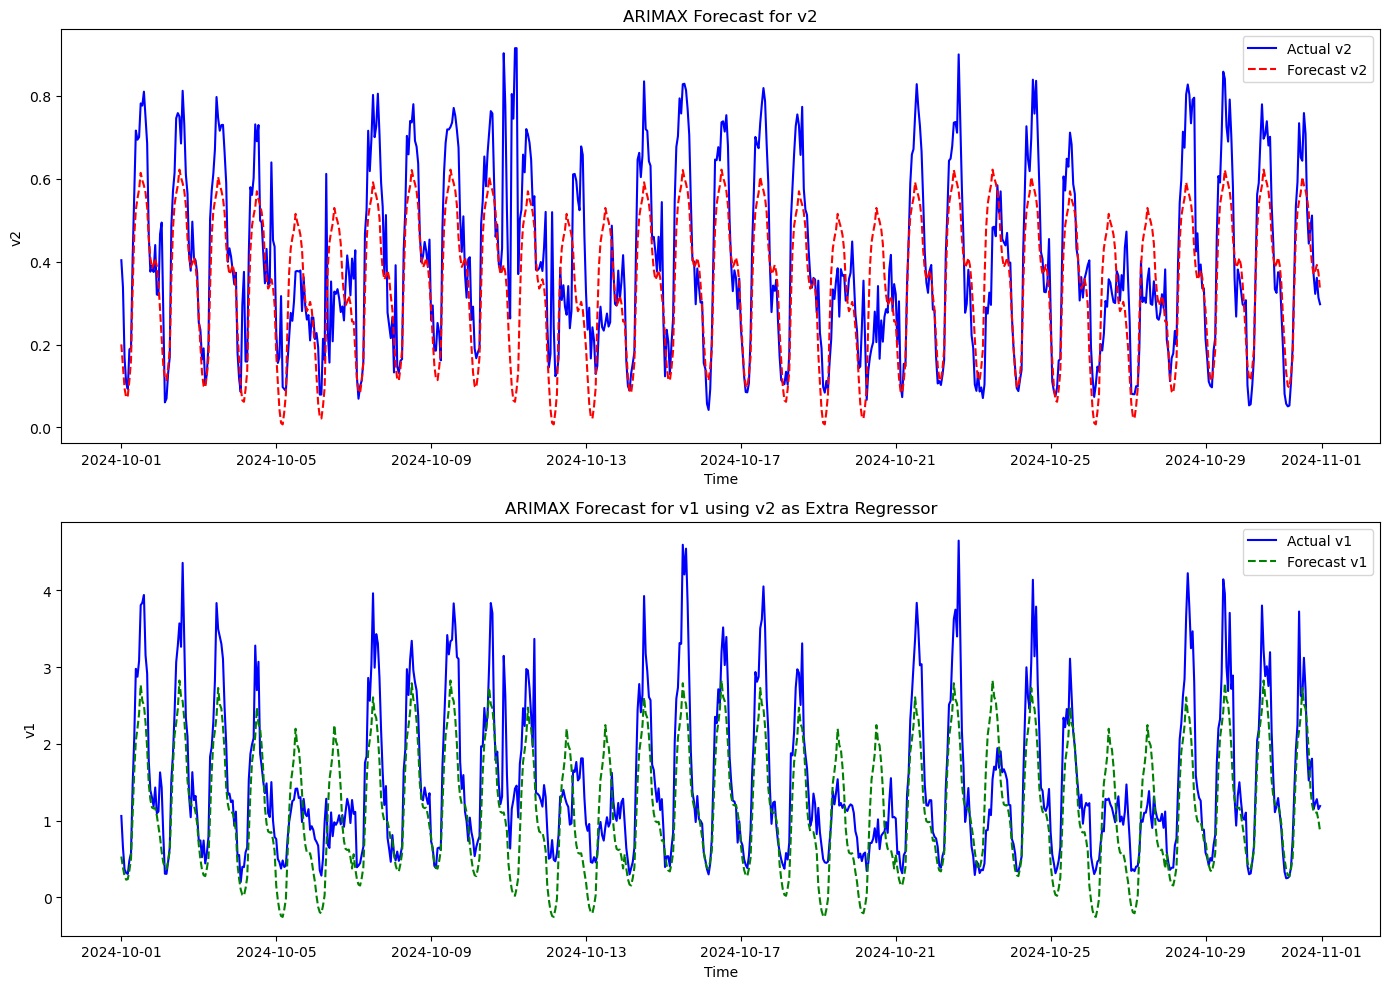

In [45]:
plt.figure(figsize=(14, 10))

# Plot v2 forecast
plt.subplot(2,1,1)
plt.plot(test['ts'], test['v2'], label='Actual v2', color='blue')
plt.plot(test['ts'], v2_pred, label='Forecast v2', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v2')
plt.title('ARIMAX Forecast for v2')
plt.legend()

# Plot v1 forecast
plt.subplot(2,1,2)
plt.plot(test['ts'], test['v1'], label='Actual v1', color='blue')
plt.plot(test['ts'], v1_pred, label='Forecast v1', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v1')
plt.title('ARIMAX Forecast for v1 using v2 as Extra Regressor')
plt.legend()

plt.tight_layout()
plt.show()

The  results are worse than prohpet model. I tried Var results were not better and they run for a really long time.

In [82]:
test = test.drop(columns=["v2_pred_with_v1", "v2_pred"])

### Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X = df.drop(columns=['v1', 'v2', 'ts', 'is_top_hour'])
y = df['is_top_hour']

# Split into training and test sets
X_train = train.drop(columns=['v1', 'v2', 'ts', 'is_top_hour'])
X_test = test.drop(columns=['v1', 'v2', 'ts', 'is_top_hour'])
y_train = train['is_top_hour']
y_test = test['is_top_hour']

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
clf.fit(X_train, y_train)

# Predict top hour status on test set
y_top_hour_pred = clf.predict(X_test)

# Evaluate performance
acc = accuracy_score(y_test, y_top_hour_pred)
print(f"Top Hour Prediction Accuracy: {acc:.3f}")


Top Hour Prediction Accuracy: 0.958


I tried to predict top hours then use this predictions. It did not lead to a better results.

In [84]:
#test['top_hour'] = y_top_hour_pred
#train['top_hour'] = train['is_top_hour']

In [85]:
feature_matrix = df.drop(columns=["v1", "v2", "ts", "is_weekend", 'is_top_hour']).select_dtypes(include=np.number)
X_train_fe = train.drop(columns=["v1", "v2", "ts", "is_weekend", 'is_top_hour']).select_dtypes(include=np.number)
X_test_fe = test.drop(columns=["v1", "v2",  "ts", "is_weekend", 'is_top_hour']).select_dtypes(include=np.number)
y_v1 = df['v1']
y_v2 = df['v2']

In [86]:
y_v1_train = train['v1']
y_v2_train = train['v2']
y_v1_test = test['v1']
y_v2_test = test['v2']

In [87]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_fe, y_v2_train)

RandomForestRegressor(random_state=42)

In [88]:
print("Feature matrix shape:", feature_matrix.shape)
print("X_train shape:", X_train_fe.shape)
print("X_test shape:", X_test_fe.shape)
print("y_v1 shape:", y_v1.shape)
print("y_v2 shape:", y_v2.shape)

Feature matrix shape: (24592, 7)
X_train shape: (23848, 7)
X_test shape: (744, 7)
y_v1 shape: (24592,)
y_v2 shape: (24592,)


In [89]:
y_v2_pred = rf.predict(X_test_fe)

# Calculate R² for v2 predictions.
r2_v2 = r2_score(y_v2_test, y_v2_pred)

print("R² for v2 prediction:", r2_v2)

R² for v2 prediction: 0.75798305444264


In [90]:
#X_test_fe = X_test_fe.drop(columns=["year"]).select_dtypes(include=np.number)
#X_train_fe = X_train_fe.drop(columns=["year"]).select_dtypes(include=np.number)

In [91]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_fe, y_v1_train)

RandomForestRegressor(random_state=42)

In [92]:
y_v1_pred = rf.predict(X_test_fe)

# Calculate R² for v2 predictions.
r2_v1 = r2_score(y_v1_test, y_v1_pred)

print("R² for v1 prediction:", r2_v1)

R² for v1 prediction: 0.8233378509340303


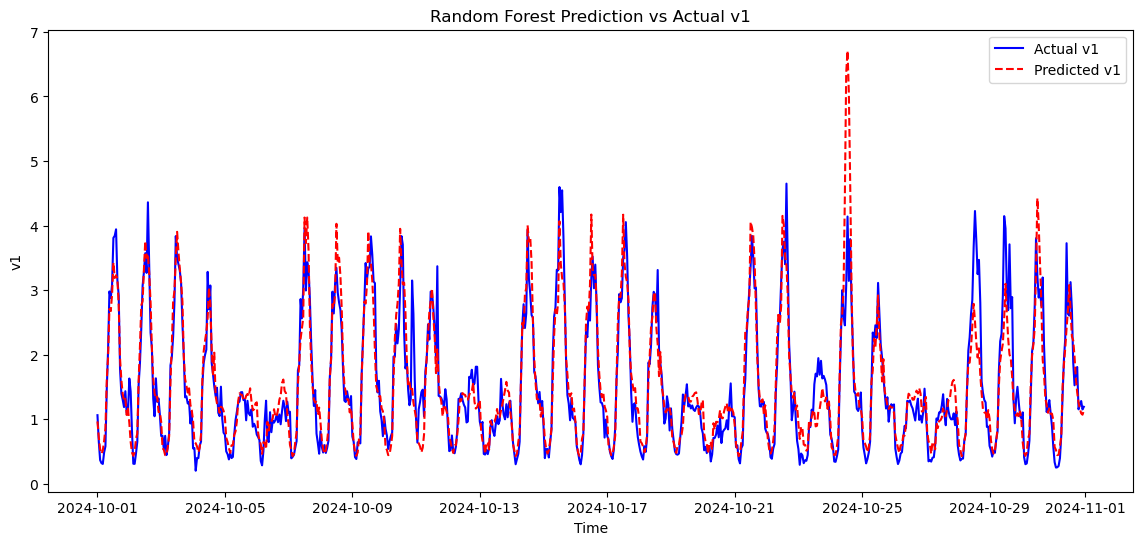

In [93]:
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v1_test, label='Actual v1', color='blue')
plt.plot(test['ts'], y_v1_pred, label='Predicted v1', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v1')
plt.title('Random Forest Prediction vs Actual v1')
plt.legend()
plt.show()

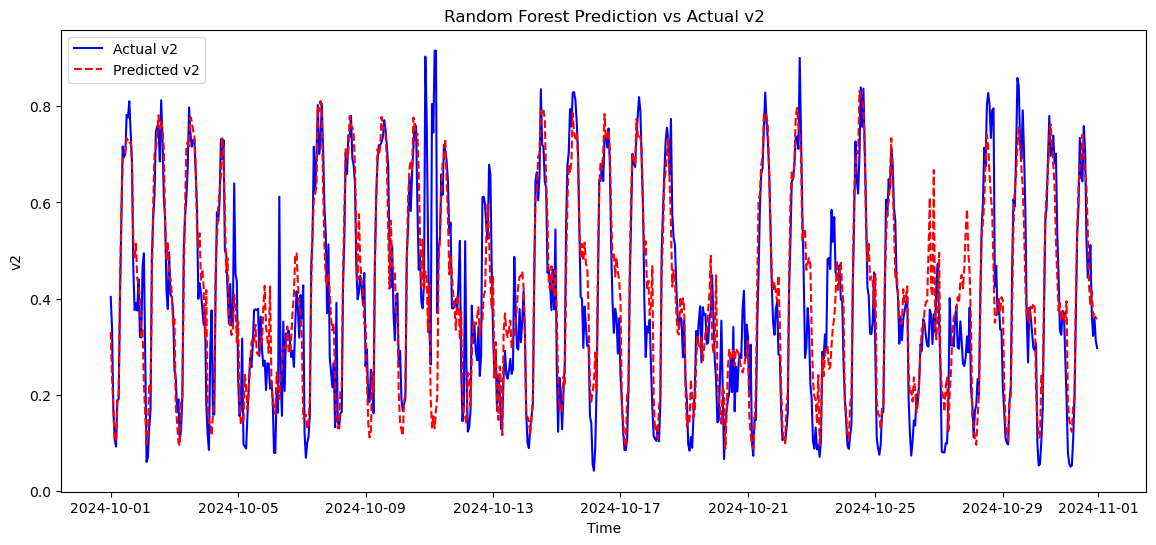

In [94]:
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v2_test, label='Actual v2', color='blue')
plt.plot(test['ts'], y_v2_pred, label='Predicted v2', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v2')
plt.title('Random Forest Prediction vs Actual v2')
plt.legend()
plt.show()

It seems like tree based methods ar the best for this prediction. Highest R ssquared we have gotten so far.

## Boosting
we will look at three boosting models:
Catboost, XGBoost, GBMboost

### Catboost

In [95]:
from catboost import CatBoostRegressor

In [96]:
cat_features = []  # e.g., cat_features = ['month', 'dow']

# Instantiate and train the CatBoostRegressor.
model = CatBoostRegressor(
    iterations=450,
    learning_rate=0.035,
    depth=5,
    verbose=100  # prints progress every 100 iterations
)

model.fit(X_train_fe, y_v2_train, cat_features=cat_features)

0:	learn: 0.2204967	total: 60.8ms	remaining: 27.3s
100:	learn: 0.0952688	total: 179ms	remaining: 620ms
200:	learn: 0.0871812	total: 300ms	remaining: 371ms
300:	learn: 0.0836367	total: 426ms	remaining: 211ms
400:	learn: 0.0814382	total: 545ms	remaining: 66.6ms
449:	learn: 0.0807373	total: 604ms	remaining: 0us


R² for CatBoost v2 prediction: 0.8066917274480505


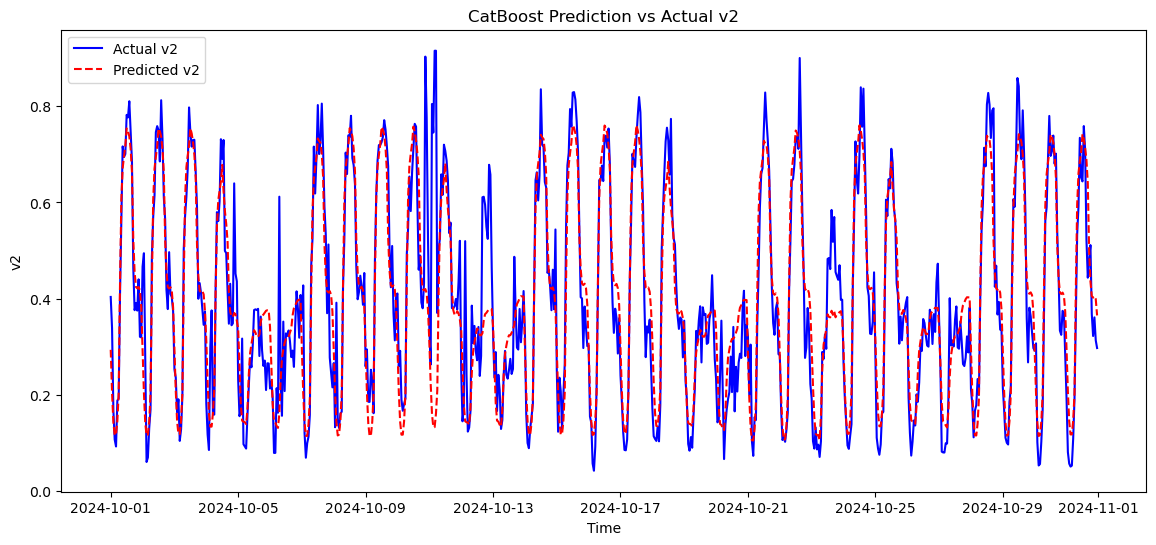

In [97]:
y_pred = model.predict(X_test_fe)

# Calculate R² score.
r2 = r2_score(y_v2_test, y_pred)
print("R² for CatBoost v2 prediction:", r2)

# Plot actual vs. predicted v2 values.
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v2_test, label='Actual v2', color='blue')
plt.plot(test['ts'], y_pred, label='Predicted v2', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v2')
plt.title('CatBoost Prediction vs Actual v2')
plt.legend()
plt.show()

In [98]:
model.fit(X_train_fe, y_v1_train, cat_features=cat_features)

0:	learn: 1.1320552	total: 2.05ms	remaining: 919ms
100:	learn: 0.5461644	total: 152ms	remaining: 524ms
200:	learn: 0.4865038	total: 270ms	remaining: 335ms
300:	learn: 0.4535536	total: 386ms	remaining: 191ms
400:	learn: 0.4326605	total: 502ms	remaining: 61.4ms
449:	learn: 0.4247490	total: 561ms	remaining: 0us


R² for CatBoost v1 prediction: 0.8953420256374192


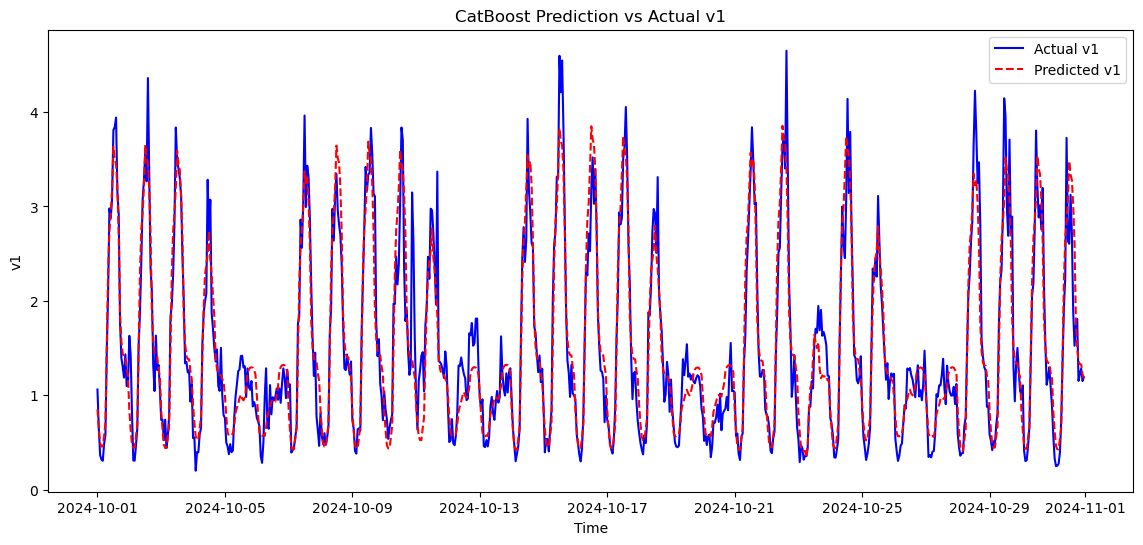

In [99]:
y_pred = model.predict(X_test_fe)

# Calculate R² score.
r2 = r2_score(y_v1_test, y_pred)
print("R² for CatBoost v1 prediction:", r2)

# Plot actual vs. predicted v2 values.
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v1_test, label='Actual v1', color='blue')
plt.plot(test['ts'], y_pred, label='Predicted v1', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v1')
plt.title('CatBoost Prediction vs Actual v1')
plt.legend()
plt.show()

### XGboost

In [100]:
from xgboost import XGBRegressor

In [101]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.035,
    max_depth=3,
    objective='reg:squarederror',  # for regression tasks
    random_state=42,
    verbosity=1
)

model.fit(X_train_fe, y_v2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.035, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R² for XGBoost v2 prediction: 0.798266087558001


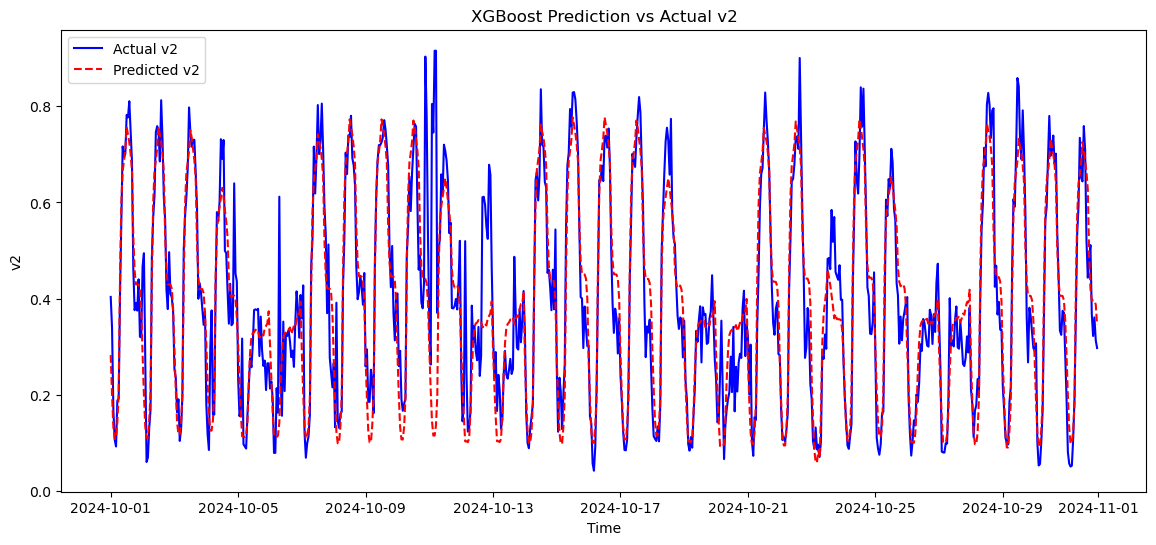

In [102]:
y_pred = model.predict(X_test_fe)

# Evaluate with R² score
r2 = r2_score(y_v2_test, y_pred)
print("R² for XGBoost v2 prediction:", r2)

# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v2_test, label='Actual v2', color='blue')
plt.plot(test['ts'], y_pred, label='Predicted v2', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v2')
plt.title('XGBoost Prediction vs Actual v2')
plt.legend()
plt.show()

In [103]:
model.fit(X_train_fe, y_v1_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.035, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R² for XGBoost v1 prediction: 0.8760536072894927


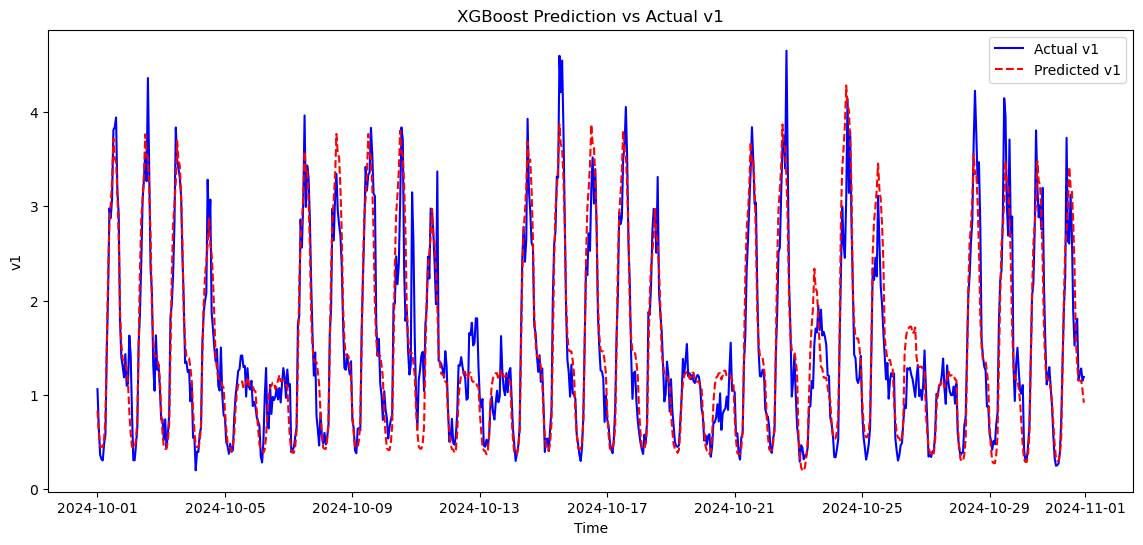

In [104]:
y_pred = model.predict(X_test_fe)

# Evaluate with R² score
r2 = r2_score(y_v1_test, y_pred)
print("R² for XGBoost v1 prediction:", r2)

# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v1_test, label='Actual v1', color='blue')
plt.plot(test['ts'], y_pred, label='Predicted v1', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v1')
plt.title('XGBoost Prediction vs Actual v1')
plt.legend()
plt.show()

### GBM boosting

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

In [106]:
gbm = GradientBoostingRegressor(
    n_estimators=300,     # number of boosting stages
    learning_rate=0.03,    # step size shrinkage
    max_depth=5,          # maximum depth of the individual regression estimators
    random_state=42
)
gbm.fit(X_train_fe, y_v2_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, n_estimators=300,
                          random_state=42)

R² for Gradient Boosting v2 prediction: 0.80477222419433


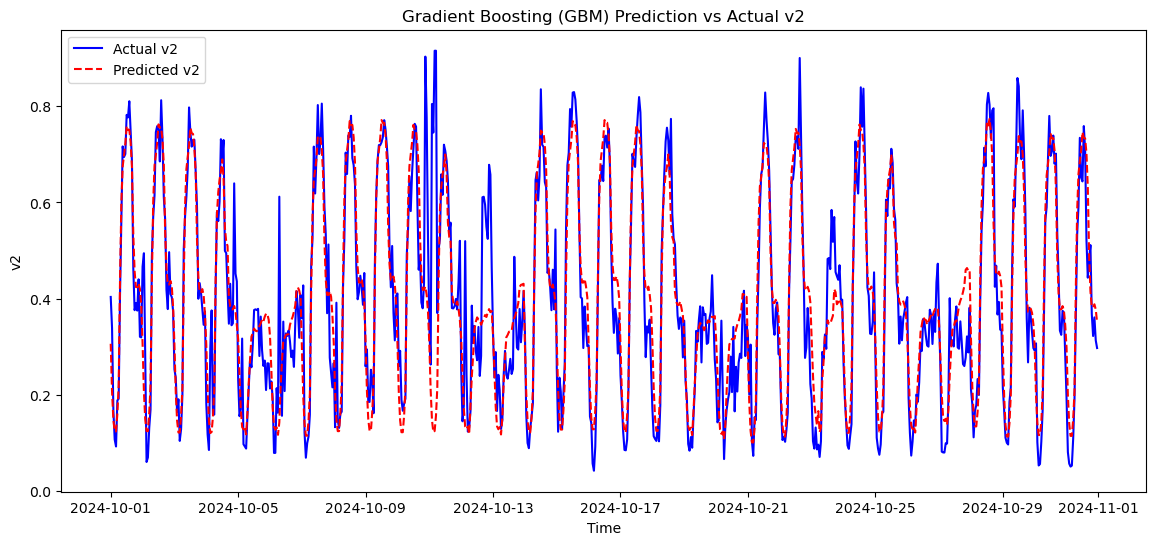

In [107]:
y_pred = gbm.predict(X_test_fe)
r2 = r2_score(y_v2_test, y_pred)
print("R² for Gradient Boosting v2 prediction:", r2)

# --- 5. Plot Actual vs. Predicted ---
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v2_test, label='Actual v2', color='blue')
plt.plot(test['ts'], y_pred, label='Predicted v2', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v2')
plt.title('Gradient Boosting (GBM) Prediction vs Actual v2')
plt.legend()
plt.show()

In [108]:
gbm.fit(X_train_fe, y_v1_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, n_estimators=300,
                          random_state=42)

R² for Gradient Boosting v1 prediction: 0.8849350495719073


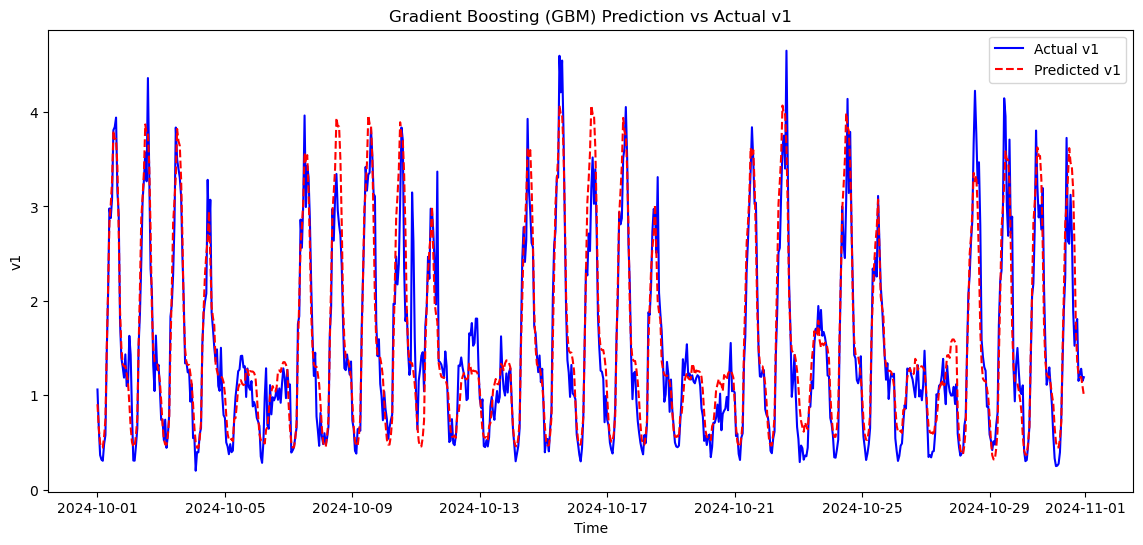

In [109]:
y_pred = gbm.predict(X_test_fe)
r2 = r2_score(y_v1_test, y_pred)
print("R² for Gradient Boosting v1 prediction:", r2)

# --- 5. Plot Actual vs. Predicted ---
plt.figure(figsize=(14,6))
plt.plot(test['ts'], y_v1_test, label='Actual v1', color='blue')
plt.plot(test['ts'], y_pred, label='Predicted v1', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('v1')
plt.title('Gradient Boosting (GBM) Prediction vs Actual v1')
plt.legend()
plt.show()

For me from the results the best is CATboost but there aren't Much differences.

## Creating data for November

In [110]:
test_df = pd.read_csv("forecast_firstname_lastname.csv")

In [111]:
test_df['ts'] = pd.to_datetime(test_df['ts'])


test_df['is_weekend'] = test_df['ts'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

us_holidays = holidays.UnitedStates(years=[2022, 2023, 2024])

#df['is_holiday'] = df['ts'].dt.date.apply(lambda d: 1 if d in us_holidays else 0)

hu_holidays = holidays.Hungary(years=range(start_year, end_year + 1))
budapest = Point(47.4979, 19.0402, 96)


test_df['hour'] = test_df['ts'].dt.hour
test_df['dow'] = test_df['ts'].dt.dayofweek
test_df['year'] = test_df['ts'].dt.year
test_df['doy'] = test_df['ts'].dt.dayofyear
test_df['month'] = test_df['ts'].dt.month
#df['dom'] = df['ts'].dt.day
#df['time_index'] = (df['ts'] - df['ts'].min()).dt.total_seconds() / 3600
test_df['is_holiday'] = test_df['ts'].dt.date.apply(lambda d: 1 if d in hu_holidays else 0)
test_df['is_weekend_and_holiday'] = ((test_df['is_weekend'] == 1) & (df['is_holiday'] == 1)).astype(int)
#df['is_working_hour'] = df['hour'].apply(lambda h: 1 if 8 <= h <= 18 else 0)
test_df.head()

Unnamed: 0                  ts  is_weekend  hour  dow  year  doy  month  \
0           0 2024-11-01 00:00:00           0     0    4  2024  306     11   
1           1 2024-11-01 01:00:00           0     1    4  2024  306     11   
2           2 2024-11-01 02:00:00           0     2    4  2024  306     11   
3           3 2024-11-01 03:00:00           0     3    4  2024  306     11   
4           4 2024-11-01 04:00:00           0     4    4  2024  306     11   

   is_holiday  is_weekend_and_holiday  
0           1                       0  
1           1                       0  
2           1                       0  
3           1                       0  
4           1                       0

## Forecasting

I choose catboost as it has the best r squared values

In [112]:
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.035,
    depth=5,
    verbose=100  # prints progress every 100 iterations
)

model.fit(feature_matrix, y_v2, cat_features=cat_features)

0:	learn: 0.2202306	total: 1.9ms	remaining: 946ms
100:	learn: 0.0953007	total: 141ms	remaining: 557ms
200:	learn: 0.0875128	total: 267ms	remaining: 397ms
300:	learn: 0.0840976	total: 391ms	remaining: 259ms
400:	learn: 0.0819228	total: 517ms	remaining: 128ms
499:	learn: 0.0806134	total: 689ms	remaining: 0us


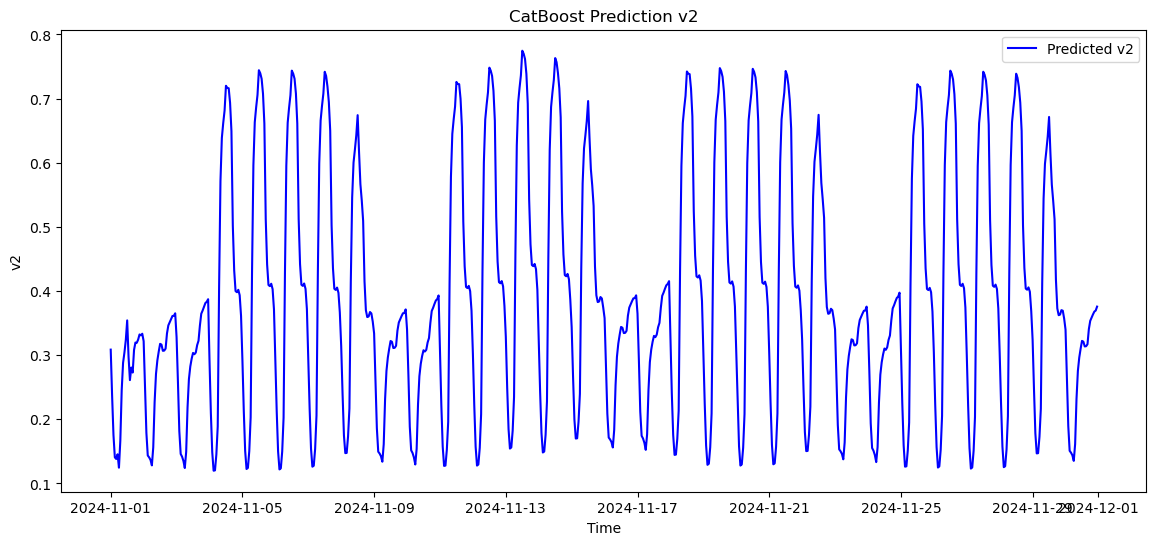

In [113]:
test_df['v2'] = model.predict(test_df)

plt.figure(figsize=(14,6))
plt.plot(test_df['ts'], test_df['v2'], label='Predicted v2', color='blue')
plt.xlabel('Time')
plt.ylabel('v2')
plt.title('CatBoost Prediction v2')
plt.legend()
plt.show()

0:	learn: 1.1273743	total: 1.7ms	remaining: 846ms
100:	learn: 0.5427247	total: 155ms	remaining: 613ms
200:	learn: 0.4828605	total: 276ms	remaining: 410ms
300:	learn: 0.4505413	total: 396ms	remaining: 262ms
400:	learn: 0.4294381	total: 519ms	remaining: 128ms
499:	learn: 0.4160505	total: 645ms	remaining: 0us


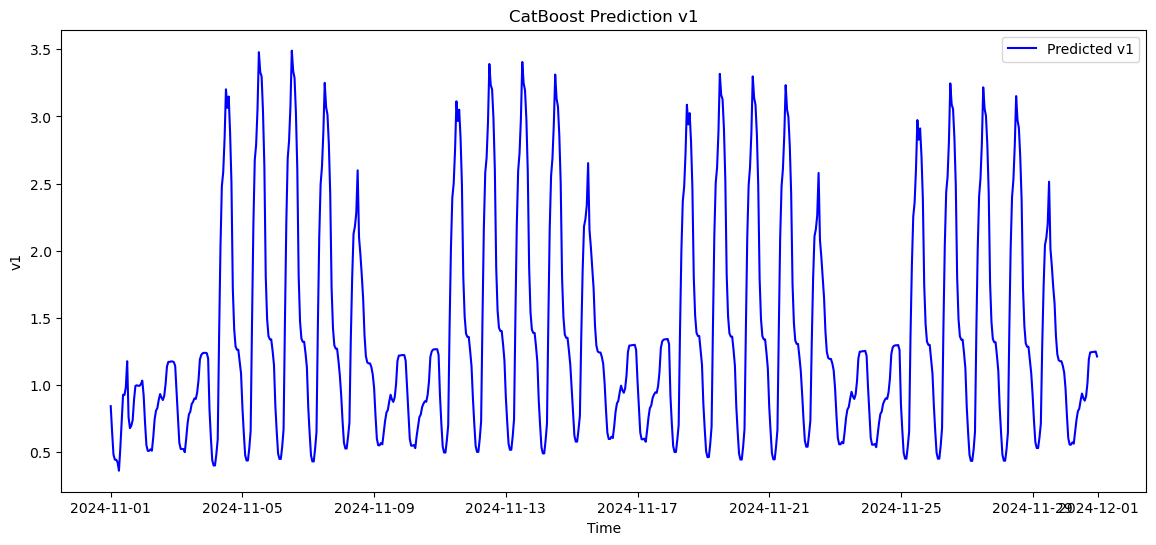

In [114]:
model.fit(feature_matrix, y_v1, cat_features=cat_features)
test_df['v1'] = model.predict(test_df)

plt.figure(figsize=(14,6))
plt.plot(test_df['ts'], test_df['v1'], label='Predicted v1', color='blue')
plt.xlabel('Time')
plt.ylabel('v1')
plt.title('CatBoost Prediction v1')
plt.legend()
plt.show()

## Exporting the data

In [115]:
test_df = test_df[['ts', 'v1', 'v2']]

In [116]:
test_df.to_csv('forecast_Murat_Tirkeshov.csv', index=False)